# Procesar y filtrar la señal de EMG

**Materias relacionadas:** Instrumentación Biomédica, Electrofisiología, Temas Selectos en Biomatemáticas y Temas Selectos en Biofísica.


**Antecedentes**: Notebook 2

## Introducción
La electromiografía (EMG) es una técnica que se utiliza para registrar la actividad eléctrica producida por los músculos esqueléticos. Esta actividad eléctrica se genera cuando las células musculares, también conocidas como fibras musculares, se activan por señales nerviosas. La EMG es una herramienta fundamental en diversas áreas, como la medicina, la fisioterapia, la ingeniería biomédica y la ergonomía, ya que permite evaluar la función muscular, diagnosticar enfermedades neuromusculares, controlar prótesis y analizar el movimiento humano.
Para adquirir las señales EMG, se utilizan electrodos que se colocan sobre la piel o, en algunos casos, se insertan directamente en el músculo. Existen dos tipos principales de electrodos: de superficie e intramusculares. Los electrodos de superficie se adhieren a la piel sobre el músculo de interés, mientras que los electrodos intramusculares son agujas finas que se insertan en el tejido muscular. La elección del tipo de electrodo depende de la aplicación específica y del nivel de detalle requerido en la señal EMG.

Para una introducción más detallada referirse a: https://github.com/emckiernan/electrophys/blob/master/EMG/EMGbasics/docs/spanish/EMGbasics_espanol.pdf

## Comparación entre las señales EMG y EEG
Tanto la EMG como la electroencefalografía (EEG) registran actividad eléctrica biológica, pero se diferencian en su origen y características. La señal EMG se origina en la actividad eléctrica de las fibras musculares durante la contracción. Cuando un impulso nervioso llega a la unión neuromuscular, se libera un neurotransmisor llamado acetilcolina, que provoca la despolarización de la membrana de la fibra muscular. Esta despolarización se propaga a lo largo de la fibra muscular, generando una corriente eléctrica que puede ser detectada por los electrodos. Por otro lado, las señales EEG se originan en la actividad sináptica de las neuronas en el cerebro. Las neuronas se comunican entre sí mediante la transmisión de señales eléctricas a través de las sinapsis. Estas señales eléctricas generan campos eléctricos que pueden ser detectados por electrodos colocados en el cuero cabelludo.
La siguiente tabla resume las key diferencias entre las señales EMG y EEG.

|Señal|Origen|Características|Aplicaciones|
|--|--|--|--|
|EMG|Atenuar las frecuencias por encima de una frecuencia de corte determinada| * Eliminar el ruido de alta frecuencia, por ejemplo el proveniente de la actividad muscular. * Aislar los componentes de baja frecuencia|
|EEG|Atenuar las frecuencias por encima de una frecuencia de corte determinada| * Eliminar el ruido causado por los cambios de potencial de la piel. * Aislar componentes de alta frecuencia|


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
import wave
import os.path as os
from scipy.fftpack import fft, ifft
from scipy.signal import filtfilt, butter

El registro tiene 1  canal/canales
La frecuencia de muestreo es de 44100 Hz.


Text(0, 0.5, 'Voltaje [microV]')

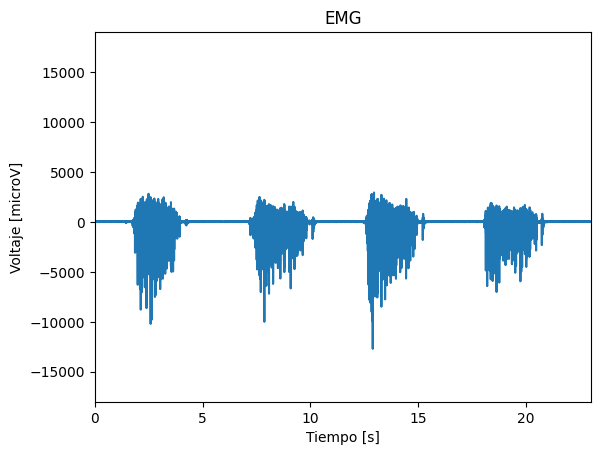

In [2]:
#Código tomado de https://github.com/emckiernan/electrophys/blob/master/EMG/EMGbasics/code/EMGanalysis.ipynb
# open .wav file by specifying the path and filename
record = wave.open('/Users/yann/Documents/Datos/EMG/S10_EMG_calf_intermittent.wav', 'r')
# extract number of channels, sample rate, data
numChannels = record.getnchannels() # number of channels
N = record.getnframes() # humber of frames
sampleRate = record.getframerate() # sampling rate
dstr = record.readframes(N * numChannels)
waveData = np.frombuffer(dstr, np.int16) 
# get the time window
timeEMG=np.linspace(0, len(waveData)/sampleRate, num=len(waveData))
# calculate frequency
freq = 1/np.mean(np.diff(timeEMG))
print('El registro tiene %d  canal/canales' % (numChannels))
print('La frecuencia de muestreo es de %d Hz.' % (sampleRate))
t0=0 #tiempo de inicio
tf=23#tiempo final
t_0=t0*sampleRate
t_f=tf*sampleRate
plt.plot(timeEMG[t_0:t_f],waveData[t_0:t_f])
plt.xlim(t0,tf)          #Eje x                                        
plt.ylim(-18000,19000)
plt.title('EMG')
plt.xlabel('Tiempo [s]')
plt.ylabel('Voltaje [microV]')

## Filtrar
Se explicarán diferentes tipos de filtros utilizados para eliminar el ruido y las interferencias de la señal EMG, como los filtros paso banda y los filtros notch.
* Filtro pasa altas: Elimina frecuencias bajas, como el ruido de la corriente eléctrica.
* Filtro pasa bajas: Elimina frecuencias altas, como las ocasionadas por el movimiento.
* Filtros paso banda: Permiten el paso de frecuencias dentro de un rango específico y atenúan las frecuencias fuera de ese rango. Son útiles para eliminar el ruido de baja frecuencia (movimiento, respiración) y el ruido de alta frecuencia (interferencias electromagnéticas). En las señales EMG, el ruido de baja frecuencia puede provenir del movimiento del paciente o del desplazamiento de los electrodos, mientras que el ruido de alta frecuencia puede ser causado por interferencias de dispositivos electrónicos cercanos. Los filtros paso banda se utilizan para aislar la banda de frecuencia de interés de la señal EMG, que generalmente se encuentra entre 20 y 500 Hz.
* Filtros notch: Eliminan frecuencias específicas, como la frecuencia de la red eléctrica (50/60 Hz), que puede interferir con la señal EMG. Este tipo de interferencia se conoce como ruido de línea de alimentación y se manifiesta como una oscilación regular en la señal EMG. Los filtros notch se diseñan para atenuar específicamente la frecuencia de la línea de alimentación, eliminando así esta interferencia.

Text(0.5, 1.0, 'Señal filtrada con pasabandas0a 23 segundos')

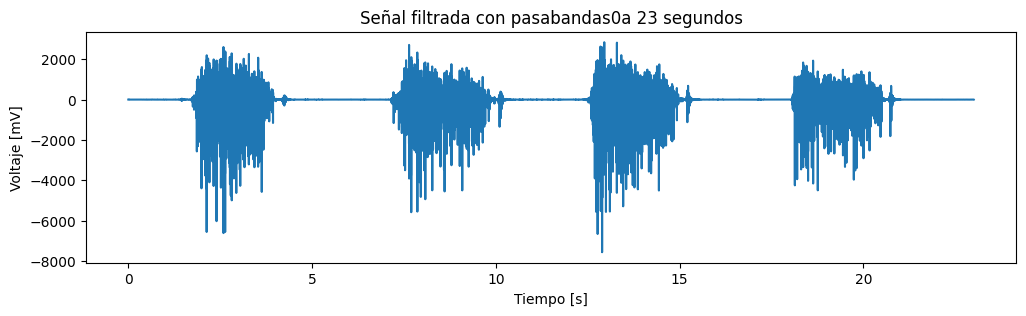

In [3]:
nyq = sampleRate*0.5 #frecuencia de muestre y ripple
low = 10 / nyq #bandwith inferior
high = 450 / nyq #bandwith superior #rangos de 2 a 45 por ruido de freq cardiaca
b, a = butter(3, [low, high], btype='band') #describir el orden de los filtros
env = filtfilt(b, a, waveData[t_0:t_f])
plt.figure(figsize=(12,3))
plt.plot(timeEMG[t_0:t_f],env)
plt.xlabel('Tiempo [s]')
plt.ylabel('Voltaje [mV]')
plt.title('Señal filtrada con pasabandas'+ str(t0) + 'a ' + str(tf)+ ' segundos')

(8.0, 9.0)

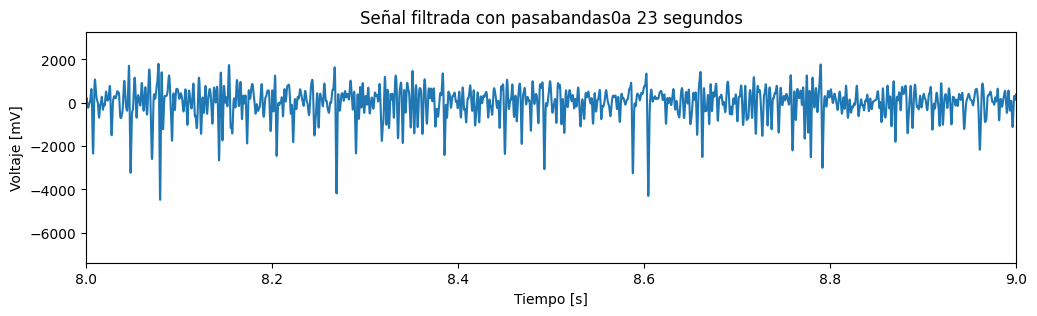

In [4]:
nyq = sampleRate*0.5 #frecuencia de muestre y ripple
low = 10 / nyq #bandwith inferior
high = 400 / nyq #bandwith superior #rangos de 2 a 45 por ruido de freq cardiaca
b, a = butter(3, [low, high], btype='band') #describir el orden de los filtros
sen_filt = filtfilt(b, a, waveData[t_0:t_f])
plt.figure(figsize=(12,3))
plt.plot(timeEMG[t_0:t_f],sen_filt)
plt.xlabel('Tiempo [s]')
plt.ylabel('Voltaje [mV]')
plt.title('Señal filtrada con pasabandas'+ str(t0) + 'a ' + str(tf)+ ' segundos')
plt.xlim(8,9)

(8.0, 9.0)

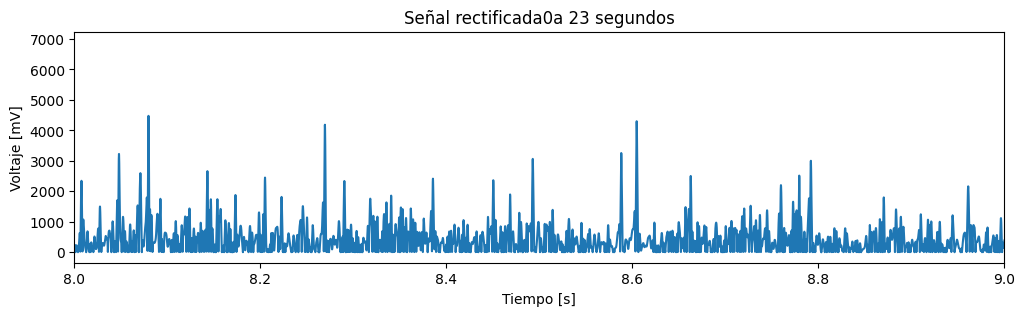

In [5]:
sen_rct = np.abs(sen_filt)
plt.figure(figsize=(12,3))
plt.plot(timeEMG[t_0:t_f],sen_rct)
plt.xlabel('Tiempo [s]')
plt.ylabel('Voltaje [mV]')
plt.title('Señal rectificada'+ str(t0) + 'a ' + str(tf)+ ' segundos')
plt.xlim(8,9)

# Protocolo 
## Filtrar
Se explicarán diferentes tipos de filtros utilizados para eliminar el ruido y las interferencias de la señal EMG, como los filtros paso banda y los filtros notch.
* Filtros paso banda: Permiten el paso de frecuencias dentro de un rango específico y atenúan las frecuencias fuera de ese rango. Son útiles para eliminar el ruido de baja frecuencia (movimiento, respiración) y el ruido de alta frecuencia (interferencias electromagnéticas). En las señales EMG, el ruido de baja frecuencia puede provenir del movimiento del paciente o del desplazamiento de los electrodos, mientras que el ruido de alta frecuencia puede ser causado por interferencias de dispositivos electrónicos cercanos. Los filtros paso banda se utilizan para aislar la banda de frecuencia de interés de la señal EMG, que generalmente se encuentra entre 20 y 500 Hz.
* Filtros notch: Eliminan frecuencias específicas, como la frecuencia de la red eléctrica (50/60 Hz), que puede interferir con la señal EMG. Este tipo de interferencia se conoce como ruido de línea de alimentación y se manifiesta como una oscilación regular en la señal EMG. Los filtros notch se diseñan para atenuar específicamente la frecuencia de la línea de alimentación, eliminando así esta interferencia.

## Rectificar 
Se utiliza para convertir la señal EMG, que tiene valores positivos y negativos, en una señal con valores solo positivos. Esto facilita la visualización y el análisis de la señal. La rectificación es necesaria porque muchas de las técnicas de análisis de señales EMG, como el cálculo del valor RMS (Root Mean Square) o la envolvente de la señal, se basan en la amplitud de la señal. Al rectificar la señal, se eliminan los valores negativos y se obtiene una señal que representa la magnitud de la actividad muscular.


* Escribir por qué no funciona con Welch
* Escribir por qué funciona con FFT
* Hacer zoom en regiones de regiones de interés